# About this notebook

This notebook demonstrates the implementation and evaluation of a custom-built Naive Bayes Classifier for a binary classification task. The steps involved in this process are:

- __Data Generation__: The `make_blobs` function from `sklearn.datasets` is used to generate a 2D synthetic dataset consisting of 100 samples, two distinct classes, and two features.

- __Data Visualization__: A scatter plot is generated using the custom `plot_dataset` function to visualize the dataset before applying the classification. The function colors the data points according to their respective classes.

- __Train-Test Split__: The dataset is split into training and testing sets. The training set is used to train the Naive Bayes Classifier, while the test set is utilized to evaluate its performance.

- __Model Training and Prediction__: An instance of the custom NaiveBayes class is created and the `fit` method is used to train the model on the training data. Following the training phase, the `predict` method is used to predict the labels of the test data.

- __Performance Evaluation__: The `accuracy_score` function from `sklearn.metrics` is used to calculate the accuracy of the model's predictions, which is the proportion of correct predictions out of all predictions.

- __Decision Boundary Visualization__: The `plot_decision_boundary` function is used to visualize the decision boundary of the trained model. This function generates a meshgrid for the feature space and predicts the class for each point, effectively displaying the regions that the model associates with each class.

In [1]:
import numpy as np
from scipy.stats import norm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Using Naïve Bayes classifier as baseline

Naïve Bayes methods are a set of supervised learning algorithms often used for text classification, spam detection, and other similar tasks. These algorithms are based on applying Bayes' theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable.

Bayes' theorem states the following relationship, given class variable \(y\) and dependent feature vector \(x_1\) through \(x_n\):

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) P(x_1, \ldots, x_n | y)}{P(x_1, \ldots, x_n)}
$$

Using the naive conditional independence assumption:

$$
P(x_i | y, x_1, \ldots, x_{i-1}, x_{i+1}, \ldots, x_n) = P(x_i | y),
$$

for all \(i\), this relationship is simplified to:

$$
P(y | x_1, \ldots, x_n) = \frac{P(y) \prod_{i=1}^n P(x_i | y)}{P(x_1, \ldots, x_n)}
$$

Now let's consider the case where the feature vector consists of words $(w_1, w_2, w_3, \dots, w_n)$. The formula for the Naive Bayes method becomes:

\begin{align*}
\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(y \mid w_1, w_2, w_3, \dots, w_n\right) &=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \frac{P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y)}{P\left(w_1, w_2, w_3, \dots, w_n\right)} \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1, w_2, w_3, \dots, w_n \mid y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } P\left(w_1 \mid y\right) \cdot \prod_{i=2}^n P\left(w_i \mid w_1, \dots, w_{i-1}, y\right) \cdot P(y) \\
&=\underset{y \in\{\text {Pos,Neg}\}}{\arg \max } \prod_{i=1}^n P\left(w_i \mid y\right) \cdot P(y)
\end{align*}

In the second line, we remove the denominator $(P\left(w_1, w_2, w_3, \dots, w_n\right))$ as it's constant given the input. In the third line, we apply the chain rule of probability. Finally, in the fourth line, we use the naive conditional independence assumption to simplify the product of conditional probabilities.

We will apply this formula in our class below. 

# Custom Naïve Bayes classifier class

In [1]:
class NaiveBayes:
    """
    A Naive Bayes Classifier that uses Gaussian distribution to estimate the likelihood.

    Methods:
    --------
    fit_distribution(data: np.array):
        Fits a Gaussian distribution to the data.

    fit(X: np.array, y: np.array):
        Fits the classifier to the data. 

    predict_proba(X: np.array):
        Predicts the probability of each class given the input features.

    predict(X: np.array):
        Predicts the class of each input sample.
        
    Attributes:
    -----------
    classes (np.array): Unique classes in the target variable.
    priors (dict): The prior probabilities of each class.
    distributions (dict): The conditional probabilities of each feature given each class.
    
    """
    def fit_distribution(self, data):
        mu = np.mean(data)
        sigma = np.std(data)
        dist = norm(mu, sigma)
        return dist

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.priors = {}  # P(y)
        self.distributions = {}  # P(w_i | y)

        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = len(X_c) / len(X)  # Calculating P(y)
            # Calculating P(w_i | y) for each feature i
            self.distributions[c] = [self.fit_distribution(
                                    X_c[:, i]) for i in range(X.shape[1])]

    def predict_proba(self, X):
        proba = np.zeros((X.shape[0], len(self.classes)))

        for i, c in enumerate(self.classes):
            prior = self.priors[c]  # P(y)
            # P(w_i | y) for each feature i
            likelihoods = [dist.pdf(X[:, j]) for j, dist in enumerate(
                           self.distributions[c])]
            # Multiplying likelihoods and prior: P(w_1 | y) * ... * P(w_n | y) * P(y)
            proba[:, i] = prior * np.prod(likelihoods, axis=0)

        # Normalizing probabilities: P(y | w_1, ..., w_n) = P(w_1 | y) * ... * P(w_n | y) * P(y) / P(w_1, ..., w_n)
        return proba / np.sum(proba, axis=1, keepdims=True)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)


# Generate dataset

In [3]:
# Generate 2D classification dataset
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and test the Naive Bayes classifier
nb = NaiveBayes()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")


Accuracy: 1.000


# Plot dataset distribution

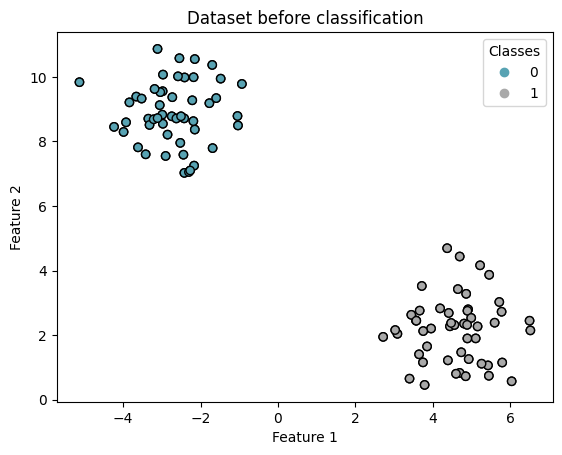

In [4]:
def plot_dataset(X, y):
    # Create a custom colormap with two colors
    custom_cmap = ListedColormap(['#58A3B3', 'darkgrey'])
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=custom_cmap)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Dataset before classification')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=custom_cmap)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()

# Plot the dataset before classification
plot_dataset(X, y)


# Plot decision boundry

In [10]:
def plot_decision_boundary(X, y, model):
    h = 0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Create a custom colormap with two colors
    custom_cmap = ListedColormap(['#58A3B3', 'darkgrey'])
    
    plt.contourf(xx, yy, Z, alpha=0.1, cmap=custom_cmap)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=custom_cmap)
    
    # Get the current axis and set xticks and yticks to be empty
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.show()


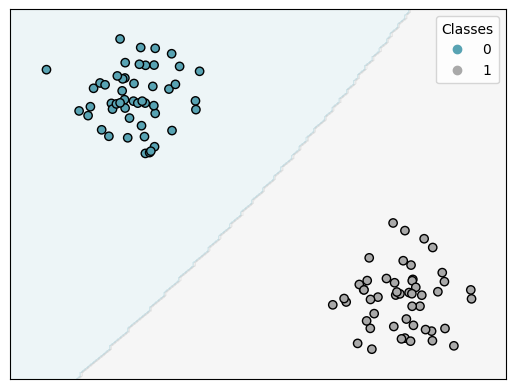

In [11]:
# Plot the decision boundary
plot_decision_boundary(X, y, nb)